## Preparation

In [1]:
# install gensim
#! pip install --quiet gensim

In [2]:
# import packages and settings
import re
import warnings
import multiprocessing
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from bs4 import BeautifulSoup
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics.pairwise import cosine_similarity
from gensim.models import Word2Vec
from scipy.spatial.distance import pdist,squareform
from functools import reduce

nlp = spacy.load('en')
cores = multiprocessing.cpu_count() - 2
warnings.filterwarnings('ignore')
google_w2v = api.load("word2vec-google-news-300")

In [3]:
# define necessary functions
def clean_yelp(s):
    s = BeautifulSoup(s, 'html5lib').get_text()
    s = ' '.join(s.split())
    s = s.strip().lower()
    return s

def tokenize(s):
    """ Returns a list of strings (tokens) from the document """
    # define and compile pattern, then return expressions that match pattern
    pattern = re.compile(r"(?u)\b\w\w+\b")
    return pattern.findall(s)
  
def test_holdout_vectors(V, y, cutoff):
    model = LogisticRegression(solver= "sag")
    model.fit(V[:cutoff], y[:cutoff])
    preds = model.predict(V[cutoff:])
    return accuracy_score(preds, y[cutoff:])
  
def embed_w2v(tokens, w2v):
    idxs = [w2v.wv.vocab.get(t) for t in tokens]
    idxs = [t.index for t in idxs if t]
    N = w2v.wv.vectors.shape[1]
    if len(idxs) < 1:
        return np.zeros(N)
    a = np.sum(w2v.wv.vectors[idxs, :], axis=0)
    a /= np.linalg.norm(a)
    return a
  
def clean_twitter(s):
    """ Cleans Twitter specific issues. Should probably clean out mentions, URLs, and RT's."""
    # all to lower case & remove emojis
    s = s.encode('ascii', 'ignore').decode('ascii')
    s = s.lower()
    # Remove mentions, URLs and RT
    s = re.sub(r"(@\w*)+", "",s)
    s = re.sub(r"(http.*)+", "",s)
    # Remove RT & amp
    s = re.sub(r"(rt)+", "",s)
    s = re.sub(r"(amp)+", "",s)
    # Lemmatizer
    doc = nlp(s)
    tok = ""
    for token in doc: 
        tok = tok + " " + token.lemma_
    tok = re.sub(r"(-.*-)+", "",tok)
    s = re.sub(r"[\"-';+:,\.=]+", "",tok)
    s = re.sub(r"(#)+", "#",s)
    s = re.sub(r"(\n)+", "",s)
    s = re.sub(' +', ' ',s)
    return s

def visualize_dist(V, tweets, idxs):
    """ Visualize distances in heatmap, V is the vector of embeddings, tweets is a list or series 
    that converts from idx to tweet, idxs is a list of integers that you would like to compare (<= 5 probably)
    """
    m = squareform(pdist(V[idxs], 'cosine'))
    _ = sns.heatmap(pd.DataFrame(m, columns = tweets[idxs], index= tweets[idxs]),xticklabels=False)

## Analysis Yelp

In [4]:
# load data
yelps = pd.read_csv('sentiment/yelps.csv').sample(frac=1).reset_index(drop=True)

In [5]:
# bulding the original TF matrix
c_vect = CountVectorizer(preprocessor= clean_yelp, tokenizer=tokenize)
yelp_TF = c_vect.fit_transform(yelps.text)

# bulding the truncated matrix
SVD = TruncatedSVD(n_components=100)
yelp_SVD = SVD.fit_transform(yelp_TF)

# check matrix sizes 
print("TF Matrix: " + str(yelp_TF.shape) + "\nTruncated Matrix: " 
      + str(yelp_SVD.shape))

TF Matrix: (100000, 78364)
Truncated Matrix: (100000, 100)


In [6]:
# clean and tokenize text, then fit three different models with Word2Vec
sentences = [tokenize(clean_yelp(i)) for i in yelps.text]

# small minimum frequency
model1 = Word2Vec(sentences, size=100, window=5, min_count=1, workers=cores)
model1.train(sentences, total_examples=1, epochs=2)
yelp_w2v_1 = np.array([embed_w2v(t, model1) for t in sentences])

# larger window of ngrams
model2 = Word2Vec(sentences, size=100, window=10, min_count=1, workers=cores)
model2.train(sentences, total_examples=1, epochs=2)
yelp_w2v_2 = np.array([embed_w2v(t, model2) for t in sentences])

# larger minimum frequency
model3 = Word2Vec(sentences, size=100, window=5, min_count=5, workers=cores)
model3.train(sentences, total_examples=1, epochs=2)
yelp_w2v_3 = np.array([embed_w2v(t, model3) for t in sentences])

# sanity check
print("Word2Vec Model 1: "   + str(model1.wv.most_similar("tasty",topn=2)) + 
      "\nWord2Vec Model 2: " + str(model2.wv.most_similar("tasty",topn=2)) + 
      "\nWord2Vec Model 3: " + str(model3.wv.most_similar("tasty",topn=2)))

Word2Vec Model 1: [('yummy', 0.8862013220787048), ('flavorful', 0.8735870718955994)]
Word2Vec Model 2: [('delicious', 0.86500483751297), ('flavorful', 0.8636627197265625)]
Word2Vec Model 3: [('yummy', 0.880753755569458), ('delicious', 0.8746709823608398)]


In [7]:
# building matrix with pretrained google news
yelp_google = np.array([embed_w2v(t, google_w2v) for t in sentences])

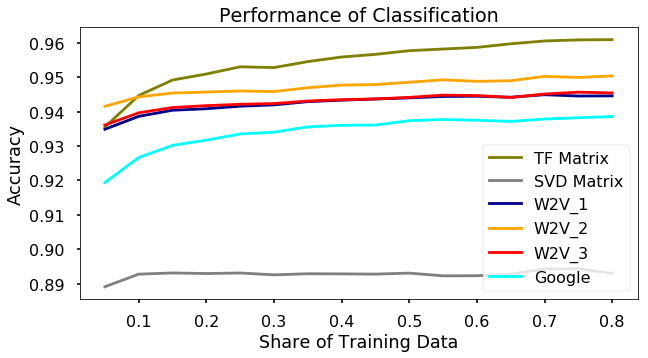

In [8]:
# define different cutoffs
shares = np.arange(0.05, 0.85, 0.05).round(2)
cutoff = list((len(yelps.positive) * shares).astype(int))


# gather scores for cutoffs
results = []
for cut_off in cutoff:
  
  # fit TF and SVD 
  reg_fit = test_holdout_vectors(yelp_TF , yelps.positive, cut_off)
  svd_fit = test_holdout_vectors(yelp_SVD, yelps.positive, cut_off)
  
  # fit word2vec models
  w2v_1 = test_holdout_vectors(yelp_w2v_1, yelps.positive, cut_off)
  w2v_2 = test_holdout_vectors(yelp_w2v_2, yelps.positive, cut_off)
  w2v_3 = test_holdout_vectors(yelp_w2v_3, yelps.positive, cut_off)
  
  # google pretrained model
  goog = test_holdout_vectors(yelp_google, yelps.positive, cut_off)
  
  # store results
  results.append([cut_off, reg_fit, svd_fit, w2v_1, w2v_2, w2v_3, goog])

  
# bring results in pd format
res = pd.DataFrame(results, columns=['share','TF','SVD','W2V_1','W2V_2','W2V_3','Google'])
res.share = shares

# plotting the gathered results
plt.style.use('seaborn-poster')
plt.figure(figsize=(10,5))
plt.plot(res.iloc[:,0],res.iloc[:,1], 'olive')
plt.plot(res.iloc[:,0],res.iloc[:,2], 'gray')
plt.plot(res.iloc[:,0],res.iloc[:,3], 'darkblue')
plt.plot(res.iloc[:,0],res.iloc[:,4], 'orange')
plt.plot(res.iloc[:,0],res.iloc[:,5], 'red')
plt.plot(res.iloc[:,0],res.iloc[:,6], 'cyan')
plt.title('Performance of Classification')
plt.ylabel('Accuracy')
plt.xlabel('Share of Training Data')
plt.legend(['TF Matrix','SVD Matrix','W2V_1','W2V_2','W2V_3','Google'])
plt.show()

Following observations: 
+ It seems that in our case the model using the full FT matrix outperforms almost regardless of the size of the training data
+ The size of the training data does not seem to have a big impact on improvement of the accuracy
+ The pretrained word2vec does not show a significant advantage, it seems that news vocabulary does not have high similarity to restaurant reviews

## Analysis Twitter

In [9]:
# Load tweets
with open('tweets/tweets.txt',encoding="utf-8") as f:
    tweets = pd.Series(f.readlines())
tweets = tweets.sample(frac=1).reset_index(drop=True)
idx = np.random.randint(0, high=len(tweets), size=5) # used for randomly picking tweets

In [10]:
# bulding the TF matrix
c_vect = CountVectorizer(preprocessor = clean_twitter, tokenizer= tokenize) 
tweet_TF = c_vect.fit_transform(tweets)

# bulding the truncated matrix
SVD = TruncatedSVD(n_components=100)  
tweet_SVD = SVD.fit_transform(tweet_TF)

# bulding the W2V model 
sentences = [tokenize(clean_twitter(i)) for i in tweets]
w2v = Word2Vec(sentences, size=100, window=10, min_count=1, workers=cores)
w2v.train(sentences, total_examples=1, epochs=2)
tweet_w2v = np.array([embed_w2v(t, w2v) for t in sentences])

# bulding the W2V model
tweet_google = np.array([embed_w2v(t, google_w2v) for t in sentences])

In [11]:
print("Similar to Trump: \n"   + str(w2v.wv.most_similar('trump',topn=2)) + 
      "\nSimilar to Hillary: \n" + str(w2v.wv.most_similar('hillary',topn=2)) + 
      "\nDifference: \n" + str(w2v.wv.most_similar(positive=['hillary'], 
                                                   negative=['trump'],topn=2)))

Similar to Trump: 
[('gop', 0.580110490322113), ('the', 0.5618786215782166)]
Similar to Hillary: 
[('hrc', 0.6693435907363892), ('hillarys', 0.6411570906639099)]
Difference: 
[('takeitdown', 0.503534734249115), ('hillaryattractsflie', 0.5026488304138184)]


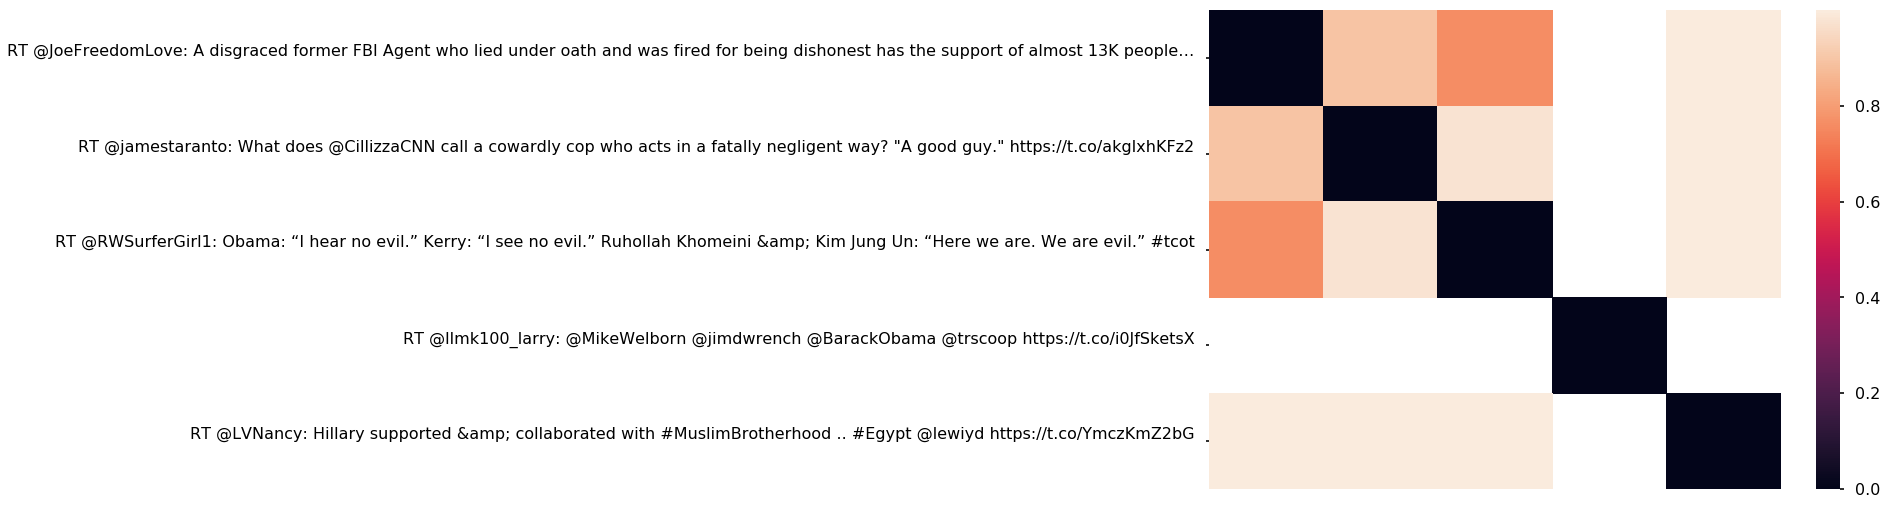

In [12]:
visualize_dist(tweet_SVD, tweets, idx)

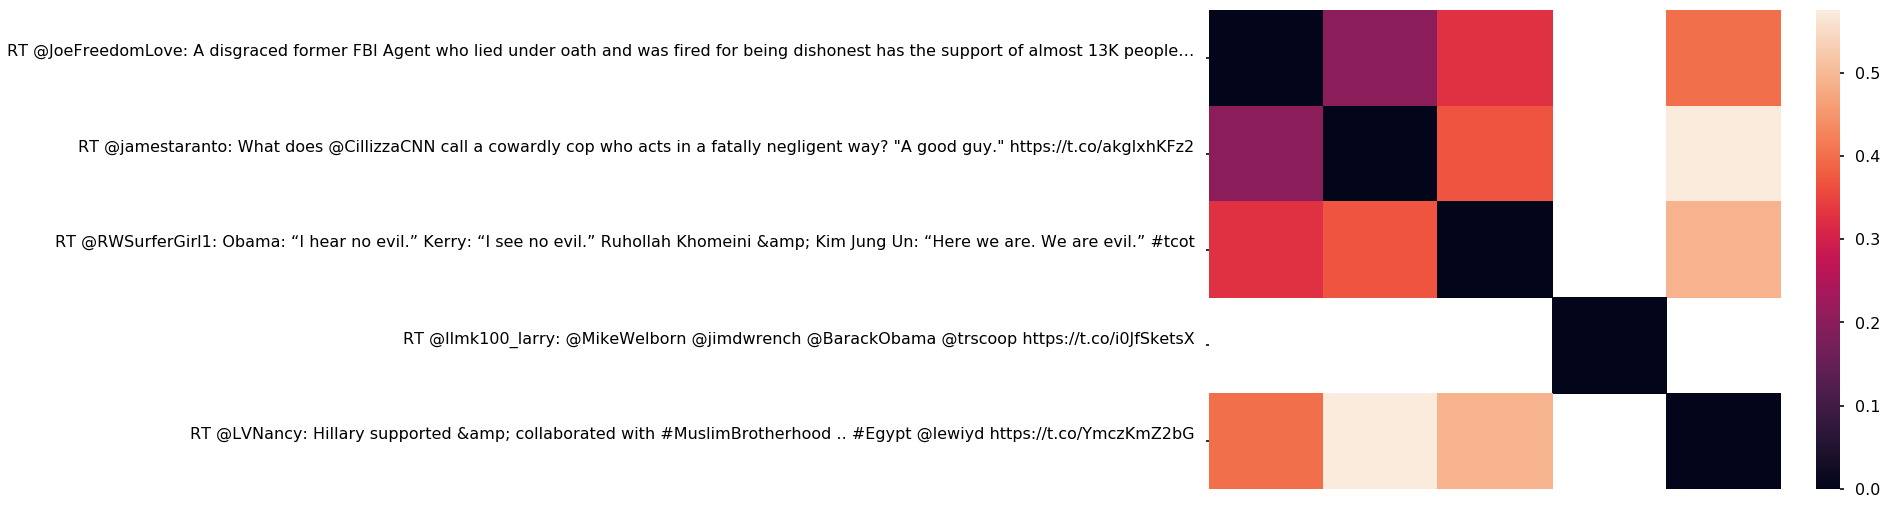

In [13]:
visualize_dist(tweet_w2v, tweets, idx)

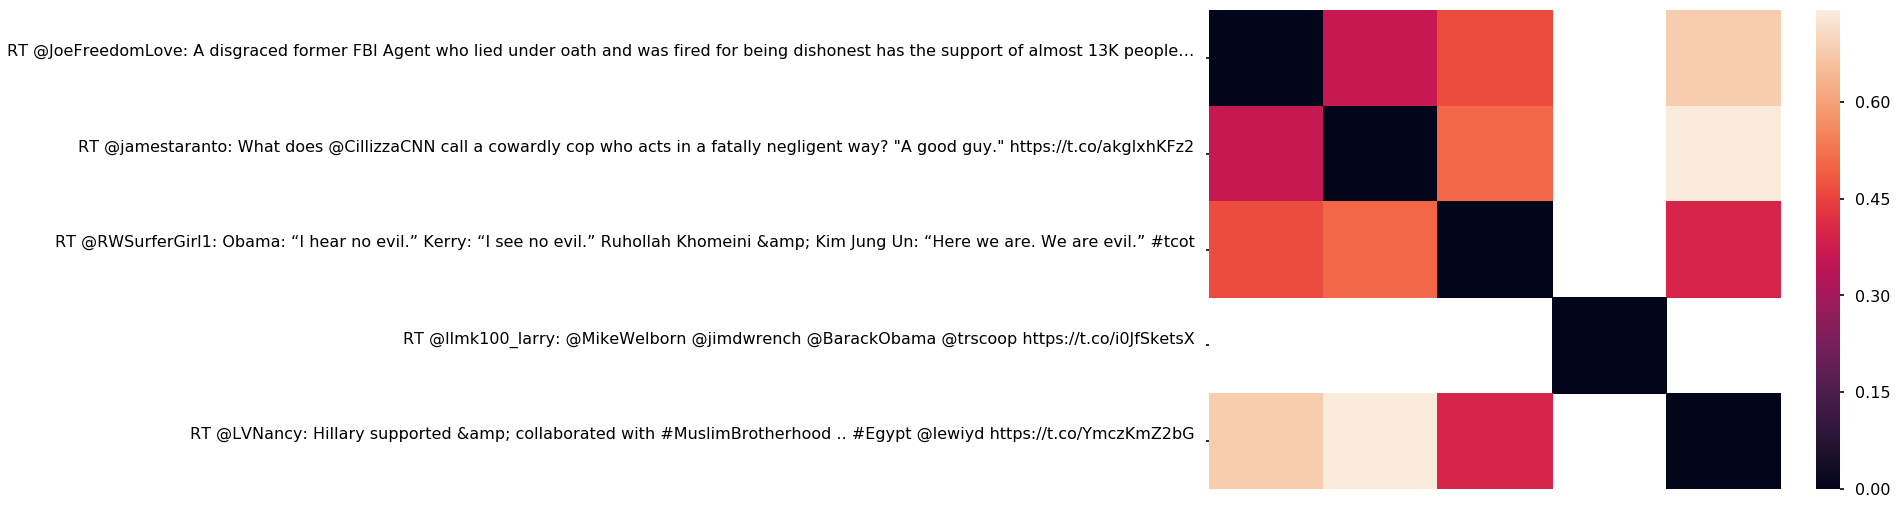

In [14]:
visualize_dist(tweet_google, tweets, idx)

Following observations: 
+ All three methods deliver consistent results
+ The models seem in general deliver decent results
+ The fourth tweet is not similar to the other ones, because it only consists of mentionings, which are filtered out in the cleaning process 